## Conversational Analysis: Topic Modeling

In [1]:
import nltk
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import word_tokenize
from copy import deepcopy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from nltk.stem import *
from nltk.stem.porter import *
from nltk.stem.lancaster import *

In [256]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [2]:
corpus_dfs = pickle.load(open('corpus_dataframes.p','rb'))

Our 3 longest transcripts by word count:
- SBC013 (12th by index in list of DataFrames)
- SBC015 (14th by index)
- SBC059 (58th)

In [3]:
for df in corpus_dfs:
    df.reset_index(drop = True, inplace = True)

In [4]:
for x in range(len(corpus_dfs)):
    for i in range(corpus_dfs[x].shape[0]):
        sentence = (corpus_dfs[x]['Utterance'][i]).replace(' ','').replace('x','').replace('X','')
        if sentence == '.':
            corpus_dfs[x].drop([i], inplace = True)

In [5]:
for df in corpus_dfs:
    df.reset_index(drop = True, inplace = True)

In [561]:
def convo_topics(conv_index,
                 num_topics,
                 min_df_in = 0.0,
                 max_df_in = 1.0,
                 ngram_range_in = (1,1),
                 max_num_topic_words = 7):

    convo_data = deepcopy(corpus_dfs[conv_index])
    
    # Running the below line should print 'ENV' if it's in the conversation
#     print(convo_data['P_Code'].unique())
    
    convo_data = convo_data[convo_data.Utterance.notnull()]
    convo_data.reset_index(drop = True, inplace = True)
    
    convo_data = convo_data[convo_data.P_Code != 'ENV']
    convo_data.reset_index(drop = True, inplace = True)
    print(convo_data['P_Code'].unique())
    
    convo_data['Utterance'] = convo_data['Utterance'].apply(word_tokenize)
    
    # stemmer = PorterStemmer()
    stemmer = LancasterStemmer()
    
    for i in range(len(convo_data['Utterance'])):
        utterance_stemmed = [stemmer.stem(word) for word in convo_data['Utterance'][i]]
        new_utterance = ' '.join(utterance_stemmed)
        convo_data['Utterance'][i] = new_utterance
    
    words = []
    for sentence in convo_data['Utterance']:
        words.append(sentence)
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range = ngram_range_in,
                                       stop_words = ENGLISH_STOP_WORDS.union('x','X','.','um','uh','hm','-','mm',','),
                                       min_df = min_df_in,
                                       max_df = max_df_in)

    tfidf_vectorizer.fit(words)
    x = tfidf_vectorizer.transform(words)
    x_back = x.toarray()
    
    df_tfidf = pd.DataFrame(x_back, columns=tfidf_vectorizer.get_feature_names())
    
    nmf_model = NMF(num_topics)
    x_nmf = nmf_model.fit_transform(x)
    
    print('x_nmf.shape: ' + str(x_nmf.shape))
    print('nmf_model.components_.shape: ' + str(nmf_model.components_.shape))
    
    topic_words = []
    words2 = tfidf_vectorizer.get_feature_names()
    for r in nmf_model.components_:
        a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:max_num_topic_words]
        topic_words.append([words2[e[1]-1] for e in a])
    
    return x_nmf, topic_words, convo_data

## Conversation: 'Stay Out Of It' - SBC042

In [594]:
topic_count = 7
a, b, c_df = convo_topics(41,
                          topic_count,
             min_df_in = 0.0,
             max_df_in = 0.02,
             ngram_range_in = (1,1),
             max_num_topic_words = 7)
b

['KEND' 'SABR' 'GEMI' 'KITT' 'MARL' 'CURT']
x_nmf.shape: (525, 7)
nmf_model.components_.shape: (7, 361)


[['mic', 'wal', 'stop', 'left', 'phon', 'thirty', 'mon'],
 ['dispos', 'spark', 'circuit', 'bef', 'bathroom', 'mayb', 'anoth'],
 ['apart', 'card', 'attitud', 'guess', 'suppos', 'thank', 'thirty'],
 ['read', 'doll', 'outsid', 'knew', 'vacu', 'siz', 'bakes'],
 ['mean', 'liv', 'let', 'ca', 'team', 'ke', 'spark'],
 ['wrot', 'rememb', 'caught', 'weekend', 'wak', 'oth', 'rip'],
 ['ago', 'lie', 'tuck', 'hold', 'numb', 'cam', 'left']]

In [595]:
b_df = pd.DataFrame(b)
b_df

,0,1,2,3,4,5,6
0,mic,wal,stop,left,phon,thirty,mon
1,dispos,spark,circuit,bef,bathroom,mayb,anoth
2,apart,card,attitud,guess,suppos,thank,thirty
3,read,doll,outsid,knew,vacu,siz,bakes
4,mean,liv,let,ca,team,ke,spark
5,wrot,rememb,caught,weekend,wak,oth,rip
6,ago,lie,tuck,hold,numb,cam,left


In [596]:
for i in range(topic_count):
    topic_column = 'Topic_' + str(i)
    c_df[topic_column] = np.nan
    for row in range(len(c_df[topic_column])):
        if sum(a[row]) == 0:
            c_df.set_value(row, topic_column, 0)
        else:
            c_df.set_value(row, topic_column, (a[row][i] / sum(a[row])))

/Users/jeremy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/jeremy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [597]:
c_df

,P_Code,Utterance,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,KEND,what 'd you do sabrin ?,0.000000,0.110803,0.000000,0.000000,0.000000,0.155928,0.733269
1,SABR,noth .,0.000000,0.071638,0.001348,0.000000,0.927014,0.000000,0.000000
2,SABR,i left the phon in my bedroom last night and s...,0.000000,0.000000,0.057583,0.000000,0.942417,0.000000,0.000000
3,SABR,it was an accid .,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,GEMI,you guy ar alway in troubl .,0.000000,0.000000,0.973927,0.000000,0.017464,0.000000,0.008609
5,GEMI,what 's up with that .,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,KEND,mom 's a bitch .,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
7,KITT,get yo feet off of ther .,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
8,KITT,get yo feet off of ther .,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
9,KEND,you 're so stupid think i spent the night .,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


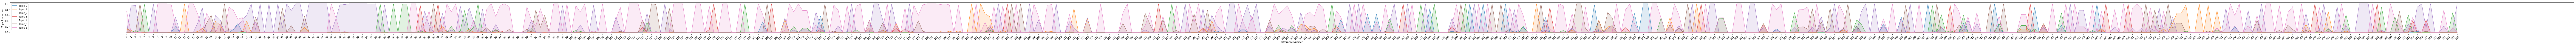

In [598]:
beginning_utterance = 0
ending_utterance = len(c_df.index)
plt.figure(figsize=(200,2.5))

topic_legend_list = []

for i in range(topic_count):
    topic_name = 'Topic_' + str(i)
    plt.fill_between((list(c_df.index.values)[beginning_utterance:ending_utterance]), (list(c_df[topic_name].values)[beginning_utterance:ending_utterance]), alpha = (1/topic_count))
    topic_legend_list.append(topic_name)
    
for i in range(topic_count):
    topic_name = 'Topic_' + str(i)
    plt.plot(((list(c_df.index.values)[beginning_utterance:ending_utterance])), (list(c_df[topic_name].values)[beginning_utterance:ending_utterance]), alpha = (0.8))
    
plt.legend(topic_legend_list, loc='upper left')

plt.ylabel('Topic Proportion')
plt.xlabel('Utterance Number')

plt.xticks(np.arange(beginning_utterance, ending_utterance, 1.0),rotation=45)

plt.show()

In [599]:
c_df.iloc[48:98]

,P_Code,Utterance,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
48,KITT,now i 'm suppos to re- a- .,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
49,KITT,and i 'm suppos to trust you every tim you tel...,0.000000,0.000000,0.000580,0.000659,0.973412,0.000000,0.025349
50,KITT,but how am i suppos to know when you 're tel t...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
51,KEND,that was a jok .,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
52,KEND,that was a jok .,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
53,KITT,yeah and i 'm suppos to read yo mind and know ...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
54,KEND,no but it was a jok .,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
55,KITT,you know kendr y- .,0.014717,0.000000,0.000000,0.000000,0.985283,0.000000,0.000000
56,KITT,i do n't know how many tim i got ta tel you on...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
57,KEND,x ar they hav a carwash ?,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [591]:
for i in range(48,72):
    print(corpus_dfs[41]['P_Code'][i])
    print(corpus_dfs[41]['Utterance'][i])

KITT
 Now I'm  supposed to re- a- .
KITT
And I'm supposed  to trust you every time you tell the truth .
KITT
 but how am I supposed to know when  you're telling the  truth  .
KEND
 That was a joke  .
KEND
 That was a joke  .
KITT
Yeah and I'm supposed to read your mind and know what you're joking about .
KEND
No but it was a joke .
KITT
You know Kendra y- .
KITT
I don't know how many times I gotta tell you once you lie once you  lie .
KEND
 X Are they having a carwash  ?
KITT
you lose th- complete  trust .
SABR
No .
KEND
Yeah they are .
KITT
Yeah that's  what it is a .
KEND
 We should have a carwash there  .
KITT
carwash and a bakesale .
KITT
They're not getting any people though .
KEND
Mm .
KEND
Hot out .
SABR
What's that supposed to be they're making it into something .
KITT
You're not going anywhere  for a while  .
KEND
 It's a bookstore  .
SABR
Really ?
KEND
God I didn't spend the night that's what makes me so mad I'm grounded for nothing .


In [592]:
# If I want the entire utterance
c_df.iloc[0]['Utterance']

"what 'd you do sabrin ?"

In [593]:
pd.Series([list(e).index(max(e)) for e in a]).value_counts()

0     134
9      88
8      68
10     62
7      60
4      31
6      28
2      20
5      18
1      10
3       6
dtype: int64

In [316]:
len([list(e).index(max(e)) for e in a if max(e)/sum(e)>0.6])

/Users/jeremy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


335

## Conversation: 'Shaggy Dog Story' - SBC060

In [620]:
topic_count = 5
a, b, c_df = convo_topics(52,
                          topic_count,
             min_df_in = 0.0,
             max_df_in = 0.02,
             ngram_range_in = (1,1),
             max_num_topic_words = 7)
b

['JUDG' 'BAIL' 'X' 'ROSE' 'X_2' 'MITC' 'MATT' 'KARE' 'MARK' 'RADI']
x_nmf.shape: (461, 5)
nmf_model.components_.shape: (5, 425)


[['th', 'help', 'read', 'black', 'discuss', 'prov', 'happy'],
 ['sint', 'allow', 'carpet', 'ment', 'window', 'build', 'prop'],
 ['leg', 'play', 'payrol', 'convint', 'mind', 'reason', 'expery'],
 ['approxim', 'remov', 'yeah', 'piec', 'mitch', 'law', 'pa'],
 ['und', 'allow', 'yeah', 'law', 'form', 'expect', 'untru']]

In [621]:
for i in range(topic_count):
    topic_column = 'Topic_' + str(i)
    c_df[topic_column] = np.nan
    for row in range(len(c_df[topic_column])):
        if sum(a[row]) == 0:
            c_df.set_value(row, topic_column, 0)
        else:
            c_df.set_value(row, topic_column, (a[row][i] / sum(a[row])))

/Users/jeremy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/jeremy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [622]:
c_df

,P_Code,Utterance,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,JUDG,okay the next cas wil be uh walt komak vers ro...,0.000000e+00,1.035009e-46,0.000000e+00,1.000000,0.000000e+00
1,BAIL,is thi contest ?,0.000000e+00,0.000000e+00,0.000000e+00,0.044683,9.553172e-01
2,X,no just wit and cas .,0.000000e+00,2.551888e-46,0.000000e+00,1.000000,0.000000e+00
3,ROSE,no .,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
4,BAIL,oh okay .,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
5,BAIL,ar you x .,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00
6,BAIL,ar you the uh plaintiff ?,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00
7,ROSE,ye .,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
8,ROSE,no .,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
9,ROSE,i 'm the defend .,0.000000e+00,1.942002e-48,0.000000e+00,1.000000,0.000000e+00


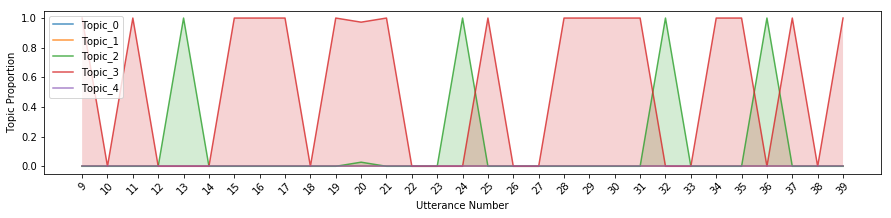

In [629]:
beginning_utterance = 9
ending_utterance = 40# len(c_df.index)
plt.figure(figsize=(15, 3))

topic_legend_list = []

for i in range(topic_count):
    topic_name = 'Topic_' + str(i)
    plt.fill_between((list(c_df.index.values)[beginning_utterance:ending_utterance]), (list(c_df[topic_name].values)[beginning_utterance:ending_utterance]), alpha = (1/topic_count))
    topic_legend_list.append(topic_name)
    
for i in range(topic_count):
    topic_name = 'Topic_' + str(i)
    plt.plot(((list(c_df.index.values)[beginning_utterance:ending_utterance])), (list(c_df[topic_name].values)[beginning_utterance:ending_utterance]), alpha = (0.8))
    
plt.legend(topic_legend_list, loc='upper left')

plt.ylabel('Topic Proportion')
plt.xlabel('Utterance Number')

plt.xticks(np.arange(beginning_utterance, ending_utterance, 1.0),rotation=45)

plt.show()

In [630]:
for i in range(9,40):
    print(i)
    print(corpus_dfs[52]['P_Code'][i])
    print(corpus_dfs[52]['Utterance'][i])

9
ROSE
I'm the defendant .
10
BAIL
 Oh  .
11
ROSE
 But I  'm the plaintiff on the countersuit .
12
BAIL
 Oh  .
13
X
Let me have this pen for a minute .
14
X_2
Oh .
15
X
   that's never worked .
16
X_2
 Yeah  .
17
ROSE
 Sign here ?
18
X
Yes .
19
JUDG
Okay now this is a case that a v- .
20
JUDG
originally was filed by Walter Komak who is now present uh not present against Rose Black um asking for a security deposit and since he's not here uh we will not rule in favor of him and then there was a cross complaint defendant's claim uh by uh Rose Black for five-hundred and thirty-three dollars balance of rent due at the end of the lease .
21
JUDG
And Miss Black I presume you're the landlord .
22
JUDG
Is that  correct  ?
23
ROSE
 Yes  .
24
ROSE
Mhm  .
25
JUDG
 And  was there a uh written agreement or a uh  lease  ?
26
ROSE
 Yes  .
27
JUDG
Was it a l- .
28
JUDG
uh month to month or a uh .
29
ROSE
A year .
30
JUDG
A one-year lease  .
31
ROSE
 One year  lease  .
32
JUDG
 Let me  see that please .

# IGNORE THE BELOW CELLS: UNNECESSARY

In [3]:
range(corpus_dfs[0].shape[0])

range(0, 667)

In [5]:
print(range(corpus_dfs[12].shape[0]))
# for i in range(len(corpus_dfs[12].count())):
#     print(corpus_dfs[12]['Utterance'][i])

range(0, 1853)


In [6]:
print(corpus_dfs[12]['Utterance'][14])

uh  I think you should   write  ...


In [7]:
sentence = (corpus_dfs[12]['Utterance'][14]).replace(' ','').replace('x','').replace('X','').replace('.','')
print(sentence)

uhIthinkyoushouldwrite


In [8]:
corpus_dfs[12].shape

(1853, 2)

In [11]:
corpus_dfs[12].shape

(1499, 2)

In [12]:
# haven't run this one yet
# for c in range(len(corpus_dfs)):
#     corpus_dfs[c]['Convo_Code'] = 'C_' + str(c)

In [13]:
corpus_dfs[12].head(25)

,P_Code,Utterance
0,KEVI,Is that just carbonated water ?
1,WEND,No thank you .
2,WEND,No .
3,KEN,No this is cream soda .
4,WEND,It's cream soda .
5,KEVI,Oh boy .
6,KEN,The best .
7,WEND,It's the best .
8,WEND,I'm sure .
9,KEND,Does it look like cream soda ?


In [16]:
df_SBC013 = deepcopy(corpus_dfs[12])

In [277]:
# unnecessary
df_SBC013['Utterance'] = df_SBC013['Utterance'].apply(word_tokenize)

In [221]:
corpus_dfs[12].head()

,P_Code,Utterance
0,KEVI,Is that just carbonated water ?
1,WEND,No thank you .
2,WEND,No .
3,KEN,No this is cream soda .
4,WEND,It's cream soda .


In [278]:
df_SBC013.head()

,P_Code,Utterance
0,KEVI,"[Is, that, just, carbonated, water, ?]"
1,WEND,"[No, thank, you, .]"
2,WEND,"[No, .]"
3,KEN,"[No, this, is, cream, soda, .]"
4,WEND,"[It, 's, cream, soda, .]"


In [295]:
# df_SBC013['Utterance'] = df_SBC013['Utterance'].apply(word_tokenize)
utterance_example = [stemmer.stem(word) for word in df_SBC013['Utterance'][0]]

In [297]:
print(df_SBC013['Utterance'][0])
print(utterance_example)
print(' '.join(utterance_example))

['Is', 'that', 'just', 'carbonated', 'water', '?']
['Is', 'that', 'just', 'carbon', 'water', '?']
Is that just carbon water ?


In [302]:
for i in range(len(df_SBC013['Utterance'])):
    utterance_stemmed = [stemmer.stem(word) for word in df_SBC013['Utterance'][i]]
    new_utterance = ' '.join(utterance_stemmed)
    df_SBC013['Utterance'][i] = new_utterance

In [303]:
print(df_SBC013['Utterance'][0])

Is that just carbon water ?


In [17]:
len(corpus_dfs[12])

1499

In [25]:
words = []
for sentence in corpus_dfs[12]['Utterance']:
    words.append(sentence)

In [27]:
words[:10]

['Is that just  carbonated water  ?',
 ' No thank you  .',
 ' No .',
 ' No this is  cream  soda .',
 "It's cream soda  .",
 ' Oh boy  .',
 'The  best .',
 "It's the best .",
 "I'm sure  .",
 ' Does it look  like cream soda ?']

In [212]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3),stop_words='english',min_df=0.00,max_df=0.3)

tfidf_vectorizer.fit(words)
x = tfidf_vectorizer.transform(words)
x_back = x.toarray()

In [213]:
df_tfidf = pd.DataFrame(x_back, columns=tfidf_vectorizer.get_feature_names())
df_tfidf

,aa,able,able figure,able figure kevin,able guess,absolutely,absolutely sense,actually,actually good,actually ones,...,yellow duck,yellow duck kitchen,yellow think,yellow think yellow,yep,yes,yogurt,yogurt cakes,yup,zooks
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [214]:
nmf_model = NMF(5)

In [215]:
x_nmf = nmf_model.fit_transform(x)

In [216]:
x_nmf.shape

(1499, 5)

In [217]:
x_nmf

array([[2.11233206e-04, 0.00000000e+00, 3.24917351e-05, 1.51238818e-03,
        1.34911142e-03],
       [6.28796734e-08, 0.00000000e+00, 0.00000000e+00, 5.61000023e-08,
        4.24058918e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       ...,
       [9.69561542e-04, 0.00000000e+00, 7.86184798e-06, 1.67769610e-03,
        9.82398175e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [218]:
nmf_model.components_.shape

(5, 2931)

In [219]:
topic_words = []
words2 = tfidf_vectorizer.get_feature_names()
for r in nmf_model.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
    topic_words.append([words2[e[1]-1] for e in a])

In [220]:
topic_words

[['offering',
  'oh works wonder',
  'oh gonna fun',
  'oh nice',
  'oil cha nge',
  'oh piece wendy',
  'uh moving beginning'],
 ['yay holy cow',
  'oh works wonder',
  'yeah probably',
  'real stuff',
  'yeah cause',
  'yeah finished',
  'yeah remember'],
 ['gonna years blow',
  'oh gonna fun',
  'real stuff',
  'really getting stupid',
  'yeah finished',
  'pretty dirty months',
  'stuff cuts blames'],
 ['twice',
  'uh think write',
  'uh moving beginning',
  'keeps coming',
  'uh diamond jim',
  'uh listen',
  'uh gonna bring'],
 ['dollars months sure',
  'knife use birthdays',
  'don heart',
  'things teeth',
  'don spit em',
  'diaper plastic bag',
  'electrically sound']]

In [268]:
stemmer = PorterStemmer()

In [276]:
stemmed_utterance = [stemmer.stem(word) for word in words]
words

['Is that just  carbonated water  ?',
 ' No thank you  .',
 ' No .',
 ' No this is  cream  soda .',
 "It's cream soda  .",
 ' Oh boy  .',
 'The  best .',
 "It's the best .",
 "I'm sure  .",
 ' Does it look  like cream soda ?',
 'Why do these cans get so warped .',
 'Only the .',
 "Only the Sam's Club cans get so  warped  .",
 'uh  I think you should   write  ...',
 " Cause they're   X  ...",
 " Cause they're   cheap cans .",
 ' Just uh write a letter to em  .',
 "that's why  ...",
 'and complain Marci .',
 "What I'm gonna complain about is that they don't make white grape .",
 'This stuff  is  good .',
 "  It's like sparkling grape juice cocktail or something you know Remember that  white  ...",
 ' They  only make that with Nutrasweet though do- .',
 "don't they .",
 "They don't make a regular ...",
 'A regular grape ?',
 "I don't  know  .",
 "Every time I've looked at the bot- that bottled water or the sparkling water  it's all   with  ...",
 " But they don't   make  this kind at all 

In [24]:
c_df

,P_Code,Utterance,Topic_by_Max
0,LENO,so you do n't nee to go borrow equip from anyb...,0
1,LENO,to do the feet ?,2
2,LENO,do the hoov ?,2
3,LYNN,wel we 're gon na hav to find somewh to get so...,2
4,DORI,so mae- ...,2
5,LYNN,i 'm gon na ...,0
6,DORI,mae lyn .,2
7,LYNN,in we 're not gon na do the feet today i 'm go...,2
8,LYNN,i mean you get so tir .,2
9,LYNN,n- you just it tak uh .,0


In [ ]:
a[1]

In [ ]:
c_df

In [393]:
list(c_df.index.values)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [167]:
plt.plot(list(c_df.index.values), list(c_df.Topic_1.values), 'ro')
plt.ylabel('some numbers')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'Topic_1'

In [265]:
# c_df['Topic_by_Max'] = pd.Series([list(e).index(max(e)) for e in a])
# """
# [list(e).index(max(e)) for e in a if max(e)/sum(e)>0.6]
# """

In [160]:
# This is incorrect - and I don't need it. We're doing a proportion above.

# for i in range(len(b)):
#     topic_column = 'Topic_ ' + str(i)
#     c_df[topic_column] = np.nan
#     for row in range(len(c_df[topic_column])):
#         c_df.set_value(row, topic_column, a[row][i])
# #         c_df[topic_column][row] = a[row][i]